In [1]:
import torchvision.models as models
import torchvision

import torch
from PIL import Image
import torchvision.transforms as transforms

import matplotlib.pyplot as plt 
import ipdb
from matplotlib.pyplot import figure

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ipdb
import copy
from tqdm import trange
from PIL import Image
import PIL
import numpy as np
import torchvision

_device = torch.device('cuda:0')

In [2]:
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [3]:
model = models.resnext50_32x4d(pretrained=True)
model.to(_device)
print('loaded')

loaded


In [4]:
data_path = '/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/notebook/images/'

image_1 = Image.open(data_path+'Bernese_mountain_dog_239.JPEG')
image_2 = Image.open(data_path+'Shetland_sheepdog_230.JPEG')
target_1 = torch.tensor([239],device=_device)
target_2 = torch.tensor([230],device=_device)

# image_1 = Image.open(data_path+'Persian_cat_283.JPEG')
# image_2 = Image.open(data_path+'tabby_cat_3_281.png')
# target_1 = torch.tensor([283],device=_device)
# target_2 = torch.tensor([281],device=_device)



transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize([200,200])
])

img_1 = (transform(image_1)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
# img_2 = (transform(image_2)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_2 = (transform(image_2)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
# img_4 = (transform(image_4)[:3,:,:].float()/255.).unsqueeze(0).to(_device)

blurr = torchvision.transforms.GaussianBlur(21, sigma=(13, 13))

In [5]:
model.eval()

delta = torch.zeros_like(img_1, requires_grad = True,device=_device)
yp = model(img_1+delta)
loss = torch.nn.CrossEntropyLoss()(yp, target_1)
loss.backward()

grad_1 = blurr(delta.grad.detach().abs().mean(dim=1)).squeeze()

delta = torch.zeros_like(img_2, requires_grad = True,device=_device)
yp = model(img_2+delta)
loss = torch.nn.CrossEntropyLoss()(yp, target_2)
loss.backward()

grad_2 = blurr(delta.grad.detach().abs().mean(dim=1)).squeeze()

In [6]:
delta.grad.detach().abs().mean(dim=1).shape

torch.Size([1, 200, 200])

In [7]:
max_criteria = 0

normalized_grad_1=grad_1/grad_1.max()
padded_grad_1 = torch.nn.functional.pad(grad_1, [200,200,200,200], mode='constant', value=0.0)
padded_normalized_grad_1 = torch.nn.functional.pad(normalized_grad_1, [200,200,200,200], mode='constant', value=0.0)
padded_img_1 = torch.nn.functional.pad(img_1, [200,200,200,200], mode='constant', value=0.0)

# padded_normalized_grad_2 = torch.nn.functional.pad(normalized_grad_2, [200,200,200,200], mode='constant', value=0.0)

saliency_sum = []
for i in range(0, 400, 10):
    for j in range(0, 400, 10):
        normalized_grad_2=grad_2/grad_2.max()
        padded_grad_2 = torch.nn.functional.pad(grad_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        padded_normalized_grad_2 = torch.nn.functional.pad(normalized_grad_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        padded_img_2 = torch.nn.functional.pad(img_2, [200-j,200+j,0+i,400-i], mode='constant', value=0.0)
        
#         M = blurr((padded_normalized_grad_1 / (padded_normalized_grad_1+padded_normalized_grad_2+1e-6)).unsqueeze(0)).squeeze()
        M = padded_normalized_grad_1 / (padded_normalized_grad_1+padded_normalized_grad_2+1e-6)
        
        M_dim_adjusted = M.view(1,1,600,600).repeat(1,3,1,1)
        
        mixed_img = (padded_img_1 * M_dim_adjusted)[:,:,200:400,200:400] + (padded_img_2 * (1-M_dim_adjusted))[:,:,200:400,200:400]
        
#         mixed_saliency = (padded_grad_1 * M)[200:400,200:400] + (padded_grad_2 * (1-M))[200:400,200:400]
        mixed_saliency = (padded_normalized_grad_1 * M)[200:400,200:400] + (padded_normalized_grad_2 * (1-M))[200:400,200:400]
        
        criteria = mixed_saliency.sum().item()
        saliency_sum.append(criteria)
        if criteria > max_criteria:
            position = [i,j]
            max_criteria = criteria
            max_saliency = mixed_saliency
            final_img = mixed_img.detach().cpu()
            final_M = M[200:400,200:400].detach().cpu()

In [30]:
position

[300, 70]

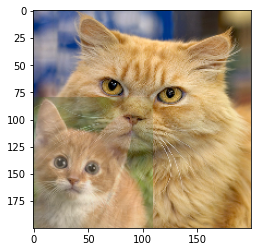

In [18]:
plt.imshow(final_img.squeeze().permute(1, 2, 0).cpu().numpy())

Text(0.5, 1.0, 'mixed images with our method')

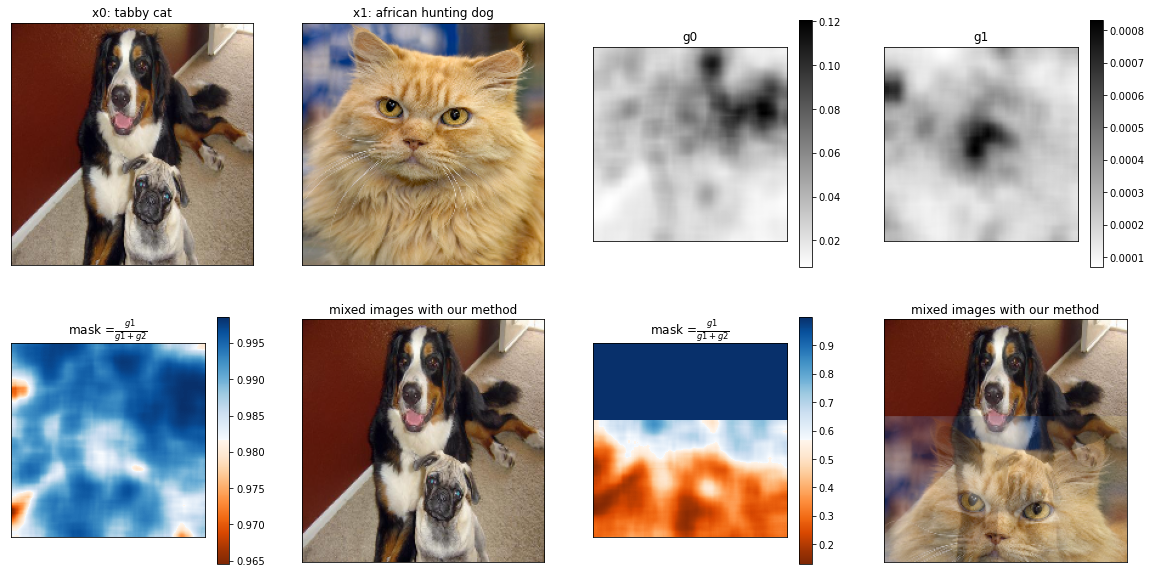

In [198]:
fix, axs = plt.subplots(ncols=4, nrows=2, squeeze=True, figsize=(20,10))

# for i,ax in enumerate(axs.flat):
im = axs.flat[0].imshow(img_1.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[0].set_title('x0: tabby cat')
im = axs.flat[1].imshow(img_2.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[1].set_title('x1: african hunting dog')

im = axs.flat[2].imshow(grad_1.t().permute(1,0).cpu().numpy(), cmap = 'binary')
axs.flat[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[2])
axs.flat[2].set_title('g0')

im = axs.flat[3].imshow(grad_2.t().permute(1,0).cpu().numpy(), cmap = 'binary')
axs.flat[3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[3])
axs.flat[3].set_title('g1')

saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
im = axs.flat[4].imshow(saliency_M, cmap = newcmp)
axs.flat[4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[4])
axs.flat[4].set_title(r'mask =$\frac{g1}{g1+g2}$')

mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[5].imshow(mixed_x.cpu().numpy())
axs.flat[5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[5].set_title('mixed images with our method')

# saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
im = axs.flat[6].imshow(final_M, cmap = newcmp)
axs.flat[6].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[6])
axs.flat[6].set_title(r'mask =$\frac{g1}{g1+g2}$')

im = axs.flat[7].imshow(final_img.squeeze().permute(1,2,0).cpu().numpy())
axs.flat[7].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[7].set_title('mixed images with our method')

# # plt.show()